<a href="https://colab.research.google.com/github/se16wangmeiwei/EDVR-predict/blob/main/edvr_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get EDVR

In [ ]:
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/xinntao/EDVR

fatal: destination path 'EDVR' already exists and is not an empty directory.


In [ ]:
cd EDVR

/content/EDVR


In [ ]:
!pip install -r requirements.txt

clear_output()

In [ ]:
!python setup.py develop
clear_output()

In [ ]:
!pip install numpy opencv-python lmdb pyyaml
clear_output()

In [ ]:
!pip install tb-nightly future
clear_output()

# Download Pre-trained Modles

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1PYULZmtpsmY4Wx8M9f4owdLIwcwQFEmi' -O EDVR_REDS_SR_L.pth
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1ZCl0aU8isEnUCsUYv9rIZZQrGo7vBFUH' -O EDVR_REDS_deblur_L.pth
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1SGVehpZt4WL_X8Jh6blyqmHpc8DdImgv' -O EDVR_REDS_deblurcomp_L.pth
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=18ev7Zx_10-C8-0tAVAe_BpYeLHpr_ChE' -O EDVR_REDS_SRblur_L.pth
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1I7x87ee3E1DoFVgMxX09nfIb2tdUdE3x' -O EDVR_Vimeo90K_SR_L.pth

clear_output()

In [ ]:
!mv /content/EDVR/EDVR_REDS_SR_L.pth /content/EDVR/experiments/pretrained_models
!mv /content/EDVR/EDVR_REDS_deblur_L.pth /content/EDVR/experiments/pretrained_models
!mv /content/EDVR/EDVR_REDS_deblurcomp_L.pth /content/EDVR/experiments/pretrained_models
!mv /content/EDVR/EDVR_REDS_SRblur_L.pth /content/EDVR/experiments/pretrained_models
!mv /content/EDVR/EDVR_Vimeo90K_SR_L.pth /content/EDVR/experiments/pretrained_models

In [ ]:
# stage 2
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1G466gQ1rRl8MUKSEbtaR0U5xgIWdsG66' -O EDVR_REDS_deblurcomp_Stage2.pth
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1kfArevFT8hzbUT2QWXFmUl983LTebQGP' -O EDVR_REDS_SR_Stage2.pth
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=13c-VxMdf8h7MGX-_y4xamxo1hhOMYzsH' -O EDVR_REDS_SRblur_Stage2.pth
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1Y1y6v40dL74Kgf5fxbGd0QC010LFCBYz' -O EDVR_REDS_deblur_Stage2.pth

clear_output()

In [ ]:
# stage 2
!mv /content/EDVR/EDVR_REDS_deblurcomp_Stage2.pth /content/EDVR/experiments/pretrained_models
!mv /content/EDVR/EDVR_REDS_SR_Stage2.pth /content/EDVR/experiments/pretrained_models
!mv /content/EDVR/EDVR_REDS_SRblur_Stage2.pth /content/EDVR/experiments/pretrained_models
!mv /content/EDVR/EDVR_REDS_deblur_Stage2.pth /content/EDVR/experiments/pretrained_models

In [ ]:
cd /content/EDVR

/content/EDVR


In [ ]:
import sys
sys.path.append('/content/EDVR/basicsr')
sys.path.append('/content/EDVR/basicsr/utils')
sys.path.append('/content/EDVR/basicsr/data')
sys.path.append('/content/EDVR/basicsr/models/archs')


# Start Pretrained

In [ ]:
def preProcess(imag_path_l, multiple):
  '''Need to resize images for blurred model (needs to be multiples of 16)'''
  im = Image.open(imag_path_l)
  h, w = im.size
  # resize so they are multiples of 4 or 16 (for blurred)
  h = h - h % multiple
  w = w - w % multiple
  im = im.resize((h,w))
  im.save(imag_path_l)

In [ ]:
import torch
import data_util
import util #这个文件是自己加载的
import edvr_arch as EDVR_arch
import glob
import os.path as ops

device = torch.device('cuda')
# 预训练模型的路径,使用vid4来进行预测
model_path = '/content/EDVR/experiments/pretrained_models/EDVR_Vimeo90K_SR_L.pth'
predeblur, HR_in = True, True
model = EDVR_arch.EDVR(num_feat=128, num_reconstruct_block=40,with_predeblur=predeblur, hr_in=HR_in)
model.load_state_dict(torch.load(model_path), strict=False)
model = model.to(device)

# 对数据进行预处理
# predeblur = True
# folder = '/content/EDVR/data'
# folder_l = sorted(glob.glob(ops.join(folder,'*')))
# if predeblur:
#   preProcess(folder_l, 16)
# else:
#   predeblur(folder_l, 4)



In [ ]:
def modcrop(img, modulo):
    (ih, iw) = img.size
    ih = ih - (ih%modulo);
    iw = iw - (iw%modulo);
    img = img.crop((0, 0, ih, iw))
    return img

In [ ]:
from PIL import Image
scale = 4
nframe = 5
tt = int(nframe/2)
filepath = '/content/drive/MyDrive/data/Vid4/foliage/003.png'
input = modcrop(Image.open(filepath).convert('RGB'),scale)
# input = target.resize((int(target.size[0]/scale),int(target.size[1]/scale)), Image.BICUBIC)
inputs = []
seq = [x for x in range(-tt, tt+1)]
char_len = len(filepath)
for i in seq:
  index = int(filepath[char_len-7:char_len-4])+i
  print(index)
  file_name1=filepath[0:char_len-7]+'{0:03d}'.format(index)+'.png'
  print(file_name1)
  if predeblur:
    preProcess(file_name1, 16)
  else:
    predeblur(file_name1, 4)
  temp = modcrop(Image.open(file_name1).convert('RGB'), scale)
  inputs.append(temp)

1
/content/drive/MyDrive/data/Vid4/foliage/001.png
2
/content/drive/MyDrive/data/Vid4/foliage/002.png
3
/content/drive/MyDrive/data/Vid4/foliage/003.png
4
/content/drive/MyDrive/data/Vid4/foliage/004.png
5
/content/drive/MyDrive/data/Vid4/foliage/005.png


In [ ]:
inputs

[<PIL.Image.Image image mode=RGB size=176x112 at 0x7F3CC92969D0>,
 <PIL.Image.Image image mode=RGB size=176x112 at 0x7F3CC9296F50>,
 <PIL.Image.Image image mode=RGB size=176x112 at 0x7F3CC92A1250>,
 <PIL.Image.Image image mode=RGB size=176x112 at 0x7F3CC92A1490>,
 <PIL.Image.Image image mode=RGB size=176x112 at 0x7F3CC92A1190>]

In [ ]:
import torchvision.transforms as transforms
import torch

transform = transforms.ToTensor()
inputs = [transform(j) for j in inputs]

In [ ]:
inputs = [j.to(device) for j in inputs]

In [ ]:
inputs = [j.reshape(1,1,3,112, 176) for j in inputs]

In [ ]:
t1 = torch.cat((inputs[0],inputs[1],inputs[2],inputs[3],inputs[4]),1)

In [ ]:
t1.to(device)

clear_output()

In [ ]:
prediction = util.single_forward(model, t1)

In [ ]:
prediction = prediction.data.cpu()

In [ ]:
prediction.shape

torch.Size([1, 3, 112, 176])

In [ ]:
unloader = transforms.ToPILImage()
prediction = prediction.squeeze(0)  # remove the fake batch dimension
prediction = unloader(prediction)

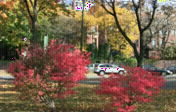

In [ ]:
prediction